## Dacon 11회 에너지 빅데이터 활용 데이터 사이언스 콘테스트
## KwangnamYu
## 2019년 10월 28일

## 1. 라이브러리 및 데이터
## Library & Data
1) 머신러닝 관련 라이브러리로 lightgbm, sklearn을 사용합니다.

2) seed를 777로 고정합니다

3) train.csv, test.csv 파일이 metric id 순으로 정렬되어 있지 않아 이를 정렬하여 사용합니다.

4) 데이터 파일 위치: 'data/'

5) train.csv, test.csv, submission_1002.csv 및 주최측으로부터 제공받은 날씨 데이터 중 '인천_시간별_기상자료(16-18)_축소_7월1일.csv' 파일을 사용합니다.

* '인천_시간별_기상자료(16-18)_축소_7월1일.csv' 파일은 인코딩 문제가 있어 텍스트로 불러옵니다.

In [1]:
# -*- coding: utf8-*-
# General Library
import numpy as np
import pandas as pd
import time
import datetime
import random
import os
import matplotlib.pyplot as plt

# Machine Learning Library
import lightgbm as lgb
import sklearn
from sklearn.model_selection import train_test_split

# Set Random Seed
seed = 777
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
random.seed(seed)

# Print Information
print('Seed: %i'%(seed))
print('Numpy: %s'%(np.__version__))
print('Pandas: %s'%(pd.__version__))
print('LightGBM: %s'%(lgb.__version__))
print('Scikit-Learn: %s'%(sklearn.__version__))

Seed: 777
Numpy: 1.17.2
Pandas: 0.25.1
LightGBM: 2.3.0
Scikit-Learn: 0.21.3


In [2]:
def sort_dataset(dataset):
    '''
    This function sorts the meteric_id of train.csv and test.csv into numerical order.
    '''
    columns = dataset.columns
    meter_ids = columns[1:]
    tmp = []
    for meter_id in meter_ids:
        meter_id = meter_id.replace('X', '')
        tmp.append(int(meter_id)) 
    tmp = np.sort(tmp)

    meter_ids = []
    for meter_id in tmp:
        meter_id = 'X' + str(meter_id)
        meter_ids.append(meter_id)

    results = [dataset[columns[0]].values]
    for meter_id in meter_ids:
        values = dataset[meter_id].values
        results.append(values)
    results = np.array(results).T
    df = pd.DataFrame(results, columns=[columns[0]] + meter_ids)
    return df

In [3]:
# Load data
train = sort_dataset(pd.read_csv('data/train.csv'))
test = sort_dataset(pd.read_csv('data/test.csv'))

# Weather data
with open('data/인천_시간별__기상자료(16-18)_축소__7월1일.csv') as file:
    additional = []
    for line in file.readlines():
        line = line.replace(',\n', ',nan')
        line = line.replace('\n', '')
        line = line.replace('뇌우끝,비', '뇌우끝_비')
        line = line.replace('뇌우,비눈', '뇌우_비눈')
        line = line.replace('뇌우끝,눈', '뇌우끝_눈')
        line = line.replace(',,', ',nan,')
        line = line.replace(',,', ',nan,')
        additional.append(line.split(','))
additional = np.array(additional)
additional_columns = additional[0]
additional_datas = additional[1:]
additional_datas_float = []
for i in range(len(additional_columns)):
    additional_data = additional_datas[:, i]
    try:
        tmp = additional_data.astype(float)
        additional_datas_float.append(tmp)
    except:
        tmp = additional_data.astype(str)
        additional_datas_float.append(tmp)

add_times = []
for item in additional_datas_float[1]:
    new_time = datetime.datetime.strptime(item, '%Y.%m.%d %H:%M')
    add_times.append(new_time)
add_times = np.array(add_times)
temperature = additional_datas_float[2]
for i in range(len(temperature)):
    if np.isnan(temperature[i]):
        temperature[i] = temperature[i-1]        
rainfall = additional_datas_float[3]
rainfall[np.where(np.isnan(rainfall) == True)[0]] = 0
wind = additional_datas_float[4]
humidity = additional_datas_float[5]
for i in range(len(humidity)):
    if np.isnan(humidity[i]):
        humidity[i] = humidity[i-1]
snowfall = additional_datas_float[6]
snowfall[np.where(np.isnan(snowfall) == True)[0]] = 0
cloud = additional_datas_float[8]
for i in range(len(cloud)):
    if np.isnan(cloud[i]):
        cloud[i] = cloud[i-1]

## 2. 데이터 전처리
## Data Cleansing & Pre-Processing
1) train, test의 결측치를 모두 0으로 변경합니다.

2) 날짜의 타입을 datetime 으로 변경합니다.

3) 시간별 날씨 데이터를 평균을 이용하여 일자별 날씨로 변경합니다.

In [4]:
def time_convert(df_time, string_type='train'):
    '''
    This function changes format of time from string to datetime.
    '''
    old_times = df_time
    new_times = old_times.copy()
    for i, old_time in enumerate(old_times):
        if string_type == 'train':
            new_time = datetime.datetime.strptime(old_time, '%Y-%m-%d %H:%M')
        elif string_type == 'test':
            new_time = datetime.datetime.strptime(old_time, '%Y.%m.%d %H:%M')
        else:
            new_time = datetime.datetime.strptime(old_time, '%Y-%m-%d')
        new_times[i] = new_time
    return new_times

def split_day(_times, _datas):
    '''
    This function splits power consumption data and weather data by days.
    '''
    for time in _times:
        if time.time().hour == 0:
            ref_time = time.date()
            break 
    times = []
    datas = []
    data_tmp = []
    for i, time in enumerate(_times):
        time = time.date()
        data = _datas[i]
        if ref_time > time:
            pass
        elif ref_time == time:
            data_tmp.append(data)
        else:
            times.append(ref_time)
            datas.append(data_tmp)
            ref_time = time
            data_tmp = [data]
    if ref_time not in times:
        if len(data_tmp) == 24:
            times.append(ref_time)
            datas.append(data_tmp)
    times = np.array(times)
    datas = np.array(datas)
    return times, datas

In [5]:
# Repalce nan to zero
train = train.replace(np.nan, 0.0)
test = test.replace(np.nan, 0.0)
# Convert time data format to datetime
train_times = time_convert(train['Time'], string_type='train').values
test_times = time_convert(test['Time'], string_type='test').values
# Meter id
train_meter_ids = train.columns[1:]
test_meter_ids = test.columns[1:]

# Downsampling (a day)
temperature = np.mean(split_day(add_times, temperature)[1], axis=1)
rainfall = np.mean(split_day(add_times, rainfall)[1], axis=1)
wind = np.mean(split_day(add_times, wind)[1], axis=1)
humidity = np.mean(split_day(add_times, humidity)[1], axis=1)
snowfall = np.mean(split_day(add_times, snowfall)[1], axis=1)
add_times, cloud = split_day(add_times, cloud)
cloud = np.mean(cloud, axis=1)

# Make additional data set
additional_data = np.array([   
    add_times,
    temperature,
    rainfall,
    wind,
    humidity,
    snowfall,
    cloud,    
])

## 3. 탐색적 자료분석
## Exploratory Data Analysis
아래 그림은 train.csv, test.csv 내 유효한 데이터 수를 보여줍니다. test.csv는 id 481번 이하로 분포하고 있으며 481번을 기준으로 데이터 수의 분포가 다릅니다. 따라서 모델 생성 시 0 ~ 481번 데이터만 사용하는 것을 고려합니다.

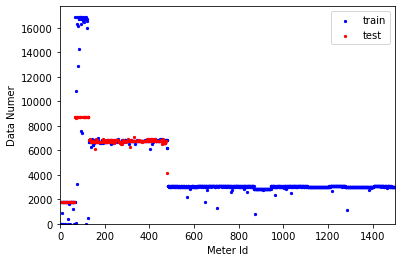

In [6]:
train_id_num = []
train_data_num = []
for meter_id in train_meter_ids:
    meter_num = int(meter_id.replace('X', ''))
    valid_num = len(np.where(train[meter_id] > 0.0)[0])
    train_id_num.append(meter_num)
    train_data_num.append(valid_num)
test_id_num = []
test_data_num = [] 
for meter_id in test_meter_ids:
    meter_num = int(meter_id.replace('X', ''))
    valid_num = len(np.where(test[meter_id] > 0.0)[0])
    test_id_num.append(meter_num)
    test_data_num.append(valid_num)
    
plt.scatter(train_id_num, train_data_num, s=5, color='b', label='train')
plt.scatter(test_id_num, test_data_num, s=5, color='r', label='test')
plt.legend()
plt.xlim(0, 1500)
plt.ylim(bottom=0)
plt.xlabel('Meter Id')
plt.ylabel('Data Numer')
plt.show()

## 4. 변수 선택 및 모델 구축
## Feature Engineering & Initial Modeling
1) 전력 데이터를 meter id 별로 따로 처리합니다.

2) 전력 데이터는 0.001 단위로 측정되어 있습니다. 너무 작은 측정값은 노이즈가 될 수 있어 0.003 보다 작은 값을 0 으로 변경합니다.

3) 전력 데이터를 다음 방법으로 정규화하여 사용합니다. (최댓값으로 나눔 > 로그를 씌움 > 평균으로 뺌 > 표준편차로 나눔)

4) 전력 데이터에 로그를 씌우기 위해 값 0을 처리합니다. (함수 consumption의 missing_value argument)

5) 전력 데이터에 해당하는 시간을 주기가 365일인 sine 함수를 이용해 인코딩하여 사용합니다. (함수 time_encoder)

6) 전력 데이터에 해당하는 요일을 Feature로 사용합니다. (월=0/6, 화=1/6, 수=2/6, 목=3/6, 금=4/6, 토=5/6, 일=6/6)

7) 2018.7.1일을 예측하는 모델은 날씨 데이터 사용을 고려합니다.

In [7]:
def consumption(_times, _datas, missing_value=None, cutoff=12):
    '''
    a) This function returns valid power consumption by days. 
    b) It turns values which are lower than 0.003 into zero.
    '''
    times, datas = split_day(_times, _datas)
    datas[np.where(datas < 3e-3)] = 0.0
    tmp = []
    for data in datas:
        if len(np.where(data > 0.0)[0]) >= cutoff:
            out = 24*np.mean(data[np.where(data > 0.0)])
            tmp.append(out)
        else:
            tmp.append(0.0)
    datas = np.array(tmp)
    
    valid_num = len(np.where(datas > 0.0)[0])
    if valid_num == 0:
        return np.array([]), np.array([])
    else:
        index_i, index_f = np.where(datas > 0.0)[0][0], np.where(datas > 0.0)[0][-1]
        times = times[index_i:index_f+1]
        datas = datas[index_i:index_f+1]
        if type(missing_value) == type(None):
            return times, datas
        elif missing_value == 0:
            return times, datas
        elif missing_value == 1:
            for i, data in enumerate(datas):
                if data == 0.0:
                    if i < 2:
                        datas[i] = datas[i-1]
                    else:
                        datas[i] = 0.2*datas[i-2] + 0.8*datas[i-1]
            return times, datas
        elif missing_value == 2:
            mean = np.mean(datas[np.where(datas > 0.0)])
            datas[np.where(datas == 0.0)] = mean
            return times, datas
        elif missing_value == 3:
            mean = gauss_mean(datas[np.where(datas > 0.0)])
            datas[np.where(datas == 0.0)] = mean
            return times, datas
        else:
            print('missing_value should be in [0, 1, 2, 3]')
            raise ValueError

def distribution_in_day(_times, _datas, set_weekday=6, start=(2018, 3, 1), cutoff=12):
    '''
    This function returns power consumption distribution in a day.
    '''    
    start_year, start_month, start_day = start
    times, datas = split_day(_times, _datas)
    dist = []
    for i, data in enumerate(datas):
        if times[i] >= datetime.date(start_year, start_month, start_day):
            if times[i].weekday() == set_weekday:
                if len(np.where(data > 0.0)[0]) >= cutoff:             
                    data = data/np.sum(data)
                    dist.append(data)
    dist = np.array(dist)
    dist = gauss_mean(dist, axis=0)
    dist = dist/np.sum(dist)
    return dist

def sequence_id(
    size, times, consums, use_weekdays=False, 
    use_times=False, add_data_sets=None, reverse=False):
    '''
    This function makes a sequence for input of a model.
    '''   
    use_additional = False
    if type(add_data_sets) != type(None):
        use_additional = True
        add_times = add_data_sets[0]
        add_data_sets = add_data_sets[1:]
    if reverse:
        times = times[::-1]
        consums = consums[::-1]
        if use_additional:
            add_times = add_times[::-1]
            add_data_sets = add_data_sets[:, ::-1]    
    if use_additional:
        ix = np.where(add_times==times[0])[0].item()

    i = 0
    sequence = []
    while True:
        times_select = times[i:i+size]
        consums_select = consums[i:i+size]
        if len(consums_select) == size:
            length = len(times_select)
            select = []
            if use_additional:
                for add_data_set in add_data_sets:
                    select.append(add_data_set[i+ix:i+ix+length])
            if use_times:
                time_encoded = []
                for time in times_select:                
                    time = time_encoder(time)
                    time_encoded.append(time)
                select.append(time_encoded)
            if use_weekdays:
                weekdays = []
                for time in times_select:
                    weekday = time.weekday()   
                    weekday /= 6
                    weekdays.append(weekday)
                select.append(weekdays)
            select.append(consums_select)

            seq = np.dstack(select)
            seq = seq.flatten()
            sequence.append(seq)
            i += 1
        else:
            sequence = np.array(sequence)
            break
    return sequence

def sequence_prediction(
    iteration, size, model, times, consums, 
    use_weekdays=False, use_times=False, add_data_sets=None, reverse=False):
    '''
    This function is for prediction (iteratable).
    '''
    use_additional = False
    if type(add_data_sets) != type(None):
        use_additional = True
        add_times = add_data_sets[0]
        add_data_sets = add_data_sets[1:]
    if reverse:
        times = times[::-1]
        consums = consums[::-1]
        if use_additional:
            add_times = add_times[::-1]
            add_data_sets = add_data_sets[:, ::-1]

    len_ini = len(times)
    times_pred = times.copy()
    consums_pred = consums.copy()
    for _ in range(iteration):
        times_select = times_pred[-(size-1):]
        if reverse:
            times_select = np.append(times_select, times_select[-1] + datetime.timedelta(days=-1))
        else:
            times_select = np.append(times_select, times_select[-1] + datetime.timedelta(days=1))
        consums_select = consums_pred[-(size-1):]
        consums_select = np.append(consums_select, 0.0)
        length = len(times_select)

        select = []
        if use_additional:
            ix = np.where(add_times==times_select[0])[0].item()
            for add_data_set in add_data_sets:
                select.append(add_data_set[ix:ix+length])
        if use_times:
            time_encoded = []
            for time in times_select:                
                time = time_encoder(time)
                time_encoded.append(time)
            select.append(time_encoded)
        if use_weekdays:
            weekdays = []
            for time in times_select:
                weekday = time.weekday()    
                weekday /= 6            
                weekdays.append(weekday)
            select.append(weekdays)
        select.append(consums_select)

        seq = np.dstack(select)
        seq = seq.flatten()[:-1]
        x_pred = seq.reshape(1, len(seq))
        y_pred = model.predict(x_pred)

        times_pred = np.append(times_pred, times_select[-1])
        consums_pred = np.append(consums_pred, y_pred)        
    times_pred = times_pred[len_ini:]
    consums_pred = consums_pred[len_ini:]
    return times_pred, consums_pred

def normalization(datas):
    '''
    The input is subtracted by its mean value and than divided by its standard deviation.
    '''
    mean = np.mean(datas)
    std = np.std(datas)
    norm = (datas - mean) / std
    return norm, mean, std

def gauss_mean(output, axis=0):
    '''
    This function returns gaussian weighted mean value of the input.
    '''    
    if output.shape[axis] <= 1:
        return np.mean(output, axis=axis)
    else:
        std = np.std(output, axis=axis)
        mean = np.mean(output, axis=axis)    
        gauss = 1/(std*np.sqrt(2*np.pi))*np.exp(-0.5 * np.square((output-mean)/std))    
        gauss_mean = np.sum(gauss*output, axis=axis)/np.sum(gauss, axis=axis)
        return gauss_mean
    
def time_encoder(time):
    '''
    This function encodes time data into a number using sine wave function (period = 365 days).
    '''
    dt = time - datetime.date(2018, 8, 1)
    dt = dt.days
    output = np.cos(2*np.pi*dt/365)
    return output

def smape(array_1, array_2):
    '''
    This function calculates SMAPE between two lists.
    '''
    score = 100*np.mean(2*abs(array_1 - array_2)/(abs(array_1)+abs(array_2)))
    return score

def r2_score(list_1, list_2):
    '''
    This function calculates R2 score between two lists.
    '''
    score = np.square(np.corrcoef(list_1, list_2)[0][1])
    return score

def lgb_train(x_train, x_valid, y_train, y_valid, feature_name=None, plot=False):
    '''
    This function returns a trained LightGBM model.
    '''
    lgb_train = lgb.Dataset(x_train, label = y_train)
    lgb_valid = lgb.Dataset(x_valid, label = y_valid)    
    params = {
        'random_seed': seed,
        'bagging_seed': seed,
        'feature_fraction_seed': seed,
        'data_random_seed': seed,
        'drop_seed': seed,
        
        'boosting_type': 'gbdt',
        'objective': 'huber',
        'learning_rate': 0.04,
        'num_leaves': 63,
        'max_depth': -1,
        'bagging_fraction': 0.1,
        'feature_fraction': 0.4,
        'lambda_l1': 10.0,
        'lambda_l2': 30.0,
        'max_bin': 255,
    }    
    model = lgb.train(
        params, 
        lgb_train, 
        valid_sets = lgb_valid,
        num_boost_round = 2000,
        early_stopping_rounds = 100,
        verbose_eval = 200,
        feature_name = feature_name,
    )
    if type(feature_name) != type(None):
        lgb.plot_importance(model, figsize=(5, len(feature_name)//5))
        plt.show()
    if plot:
        true = y_valid
        pred = model.predict(x_valid)
        score = r2_score(true, pred)
        plt.title('R2: %f'%(score))
        plt.scatter(true, pred)
        plt.plot([true.min(), true.max()], [true.min(), true.max()], color='k')
        plt.show()
    return model

## 5. 모델 학습 및 검증
## Model Tuning & Evaluation
1) 조건에 따라 18개 모델을 생성합니다.

    a) Meter ID 범위: 0 ~ 481 / 0 ~ 1500

    b) 전력 데이터 중 0 에 대한 처리를 3종류로 분류 (missing_value = 1, 2, and 3)

    c) 2018.07.01 예측에 날씨 데이터 사용 여부

    d) 날씨 데이터 사용 시 2018.07.01 이후 예측을 위해 데이터 길이 여부 (74일 / 75일)
    
2) 2018.7.1(일요일)의 시간별 예측을 위해 2018.3.1~2018.6.30 중 일요일에 해당하는 데이터를 사용합니다. gaussian weighted mean을 사용해 시간에 따른 분포를 구하여 예측합니다. (함수 gauss_mean)

3) 첫 loop에서 'temp/' 폴더를 생성하며 각 모델은 submission과 동일한 포맷의 파일을 'temp/' 폴더 안에 생성합니다.

In [8]:
def main(file_name, set_last_id_num=481, missing_value=2, sizes=[74, 74], pred_sizes=[1, 152], additional=False, two_step=False):
    '''
    a) This function trains a model (or two models) and predicts future power consumptions.
    b) This function makes a directory 'temp/' and writes a temporary result file in the directory.
    '''    
    start_time = time.time()
    # Set meter id range and missing value process
    set_last_id_num = set_last_id_num
    missing_value = missing_value
    
    # Make a dictionary with valid data
    valid_data = {}
    for meter_id in train_meter_ids:
        id_num = int(meter_id.replace('X', ''))
        if id_num <= set_last_id_num:
            times, consums = consumption(train_times, train[meter_id], missing_value=missing_value)
            valid_data[meter_id] = {'time': times, 'data': consums}
            print('Loading: %5s'%(meter_id), end='\r')
    for meter_id in test_meter_ids:
        id_num = int(meter_id.replace('X', ''))
        if id_num <= set_last_id_num:
            times, consums = consumption(test_times, test[meter_id], missing_value=missing_value)
            valid_data[meter_id] = {'time': times, 'data': consums}
            print('Loading: %5s'%(meter_id), end='\r')

    # Meter id list
    meter_ids = np.array(list(valid_data.keys()))
    meter_num = []
    for meter_id in meter_ids:
        num = int(meter_id.replace('X', ''))
        meter_num.append(num)
    meter_num = np.array(meter_num)
    meter_ids = meter_ids[np.argsort(meter_num)]
    
    # Data set parameters
    size = sizes[0]
    use_weekdays = True
    use_times = True
    if additional:
        add_data_sets = additional_data
    else:
        add_data_sets = None
    valid_data_added = valid_data.copy()

    # Make train/validation/test set
    X_, y_ = [], []
    for meter_id in meter_ids:
        times, consums = valid_data_added[meter_id]['time'], valid_data_added[meter_id]['data']
        if len(consums) >= size:
            data_in = consums/np.max(consums)
            data_in = np.log(data_in)
            data_in = normalization(data_in)[0]
            sequence = sequence_id(
                size, times, data_in, 
                use_weekdays=use_weekdays, use_times=use_times, add_data_sets=add_data_sets, reverse=False)
            X, y = sequence[:, :-1], sequence[:, -1]
            X_.append(X)
            y_.append(y)
    X_, y_ = np.concatenate(X_, axis=0).astype('float'), np.concatenate(y_, axis=0).astype('float')
    x_train, x_remain, y_train, y_remain = train_test_split(X_, y_, test_size = 0.2, random_state=seed)
    x_valid, x_test, y_valid, y_test = train_test_split(x_remain, y_remain, test_size = 0.5, random_state=seed)
    print('Feature: %i, Total: %i, Train: %i, Validation: %i, Test: %i'
          %(X_.shape[1], X_.shape[0], x_train.shape[0], x_valid.shape[0], x_test.shape[0]))
    
    # Train model 1
    lgb_model = lgb_train(x_train, x_valid, y_train, y_valid, feature_name=None, plot=False)
    lgb_test, lgb_valid = lgb_model.predict(x_test).flatten(), lgb_model.predict(x_valid).flatten()
    lgb_test_score, lgb_valid_score = r2_score(y_test, lgb_test), r2_score(y_valid, lgb_valid)
    print('Test score: %f, Valid score: %f'%(lgb_test_score, lgb_valid_score))
    
    # Predict 2018.7.1
    pred_size = pred_sizes[0]
    if two_step:
        selected_meter_ids = meter_ids
    else:
        selected_meter_ids = test_meter_ids
    for meter_id in selected_meter_ids:
        times, consums = valid_data_added[meter_id]['time'], valid_data_added[meter_id]['data']
        if len(times) >= size-1:            
            consums_max = np.max(consums)
            data_in = consums/consums_max
            data_in = np.log(data_in)
            data_in, mean, std = normalization(data_in)        
            pred_times, pred_consums = sequence_prediction(
                pred_size, size, lgb_model, times, data_in, 
                use_weekdays=use_weekdays, use_times=use_times, add_data_sets=add_data_sets, reverse=False)
            pred_consums = pred_consums*std+mean
            pred_consums = np.exp(pred_consums)
            pred_consums = pred_consums*consums_max
            last_day = pred_times[-1]
            times = np.append(times, pred_times)
            consums = np.append(consums, pred_consums)
            valid_data_added[meter_id] = {'time': times, 'data': consums}        
        else:
            valid_data_added[meter_id] = {'time': times, 'data': consums} 
    print('Last Day: {}'.format(last_day))
    
    if two_step:
        # Data set parameters
        size = sizes[1]
        use_weekdays = True
        use_times = True
        add_data_sets = None

        # Make train/validation/test set
        X_, y_ = [], []
        for meter_id in meter_ids:
            times, consums = valid_data_added[meter_id]['time'], valid_data_added[meter_id]['data']
            if len(times) >= size:
                data_in = consums/np.max(consums)
                data_in = np.log(data_in)
                data_in = normalization(data_in)[0]
                sequence = sequence_id(
                    size, times, data_in, 
                    use_weekdays=use_weekdays, use_times=use_times, add_data_sets=add_data_sets, reverse=False)
                X, y = sequence[:, :-1], sequence[:, -1]
                X_.append(X)
                y_.append(y)
        X_, y_ = np.concatenate(X_, axis=0).astype('float'), np.concatenate(y_, axis=0).astype('float')
        x_train, x_remain, y_train, y_remain = train_test_split(X_, y_, test_size = 0.2, random_state=seed)
        x_valid, x_test, y_valid, y_test = train_test_split(x_remain, y_remain, test_size = 0.5, random_state=seed)
        print('Feature: %i, Total: %i, Train: %i, Validation: %i, Test: %i'
              %(X_.shape[1], X_.shape[0], x_train.shape[0], x_valid.shape[0], x_test.shape[0]))

        # Train model 2
        lgb_model = lgb_train(x_train, x_valid, y_train, y_valid, feature_name=None, plot=False)
        lgb_test, lgb_valid = lgb_model.predict(x_test).flatten(), lgb_model.predict(x_valid).flatten()
        lgb_test_score, lgb_valid_score = r2_score(y_test, lgb_test), r2_score(y_valid, lgb_valid)
        print('Test score: %f, Valid score: %f'%(lgb_test_score, lgb_valid_score))

        # Predict 2018.7.2 ~ 2018.11.30
        pred_size = pred_sizes[1]
        for meter_id in test_meter_ids:
            times, consums = valid_data_added[meter_id]['time'], valid_data_added[meter_id]['data']
            if len(times) >= size-1:
                consums_max = np.max(consums)
                data_in = consums/consums_max
                data_in = np.log(data_in)
                data_in, mean, std = normalization(data_in)
                pred_times, pred_consums = sequence_prediction(
                    pred_size, size, lgb_model, times, data_in,
                    use_weekdays=use_weekdays, use_times=use_times, add_data_sets=add_data_sets, reverse=False)
                pred_consums = pred_consums*std+mean
                pred_consums = np.exp(pred_consums)
                pred_consums = pred_consums*consums_max    
                last_day = pred_times[-1]
                times = np.append(times, pred_times)
                consums = np.append(consums, pred_consums)
                valid_data_added[meter_id] = {'time': times, 'data': consums}        
            else:
                valid_data_added[meter_id] = {'time': times, 'data': consums} 
        print('Last Day: {}'.format(last_day))
    
    # Write a result file  
    dir_name = 'temp/'
    if not os.path.isdir(dir_name):
        os.mkdir(dir_name)
    file_name = file_name   
    submission = pd.read_csv('data/submission_1002.csv')
    submission_meter_ids = submission['meter_id'].values
    for i, meter_id in enumerate(submission_meter_ids):
        times, consums = test_times, test[meter_id]
        distribution = distribution_in_day(times, consums, set_weekday=6, start=(2018, 3, 1))

        times, consums = valid_data_added[meter_id]['time'], valid_data_added[meter_id]['data']
        index_i = np.where(times == datetime.date(2018, 7, 1))[0].item()
        index_f = np.where(times == datetime.date(2018, 11, 30))[0].item()
        times, consums = times[index_i:index_f+1], consums[index_i:index_f+1]

        output_2018_7_1_h = distribution * consums[0]
        output_2018_7_1_10_d = consums[0:10]
        output_2018_07_m = np.sum(consums[0:31])
        output_2018_08_m = np.sum(consums[31:62])
        output_2018_09_m = np.sum(consums[62:92])
        output_2018_10_m = np.sum(consums[92:123])
        output_2018_11_m = np.sum(consums[123:153])
        output = np.append([meter_id], output_2018_7_1_h)
        output = np.append(output, output_2018_7_1_10_d)
        output = np.append(output, [output_2018_07_m, output_2018_08_m, output_2018_09_m, output_2018_10_m, output_2018_11_m])
        submission.loc[i] = output

    df = pd.DataFrame(submission, columns=submission.columns)
    df.to_csv(dir_name + file_name, header=True, index=False)
    
    # Print the process time
    process_time = time.time() - start_time
    minute = process_time//60
    second = int(process_time - 60*minute)
    print('Process Time: %i m %i s'%(minute, second))
    print('')
    return valid_data_added

In [9]:
# Run
results = []
counter = 0
for set_last_id_num in [481, 1500]:
    for missing_value in [1, 2, 3]:
        print('Result %i'%(counter))
        results.append(
            main(
                'result_' + str(counter).zfill(2) + '.csv', 
                set_last_id_num=set_last_id_num, 
                missing_value=missing_value, 
                sizes=[74, 74], 
                pred_sizes=[1, 152], 
                additional=True, 
                two_step=True,
            )
        )
        counter += 1
        
        print('Result %i'%(counter))
        results.append(
            main(
                'result_' + str(counter).zfill(2) + '.csv', 
                set_last_id_num=set_last_id_num, 
                missing_value=missing_value, 
                sizes=[74, 75], 
                pred_sizes=[1, 152], 
                additional=True, 
                two_step=True,
            )
        )
        counter += 1
        
        print('Result %i'%(counter))
        results.append(
            main(
                'result_' + str(counter).zfill(2) + '.csv', 
                set_last_id_num=set_last_id_num, 
                missing_value=missing_value, 
                sizes=[74, _], 
                pred_sizes=[153, _], 
                additional=False, 
                two_step=False,
            )
        )
        counter += 1

Result 0
Feature: 665, Total: 110465, Train: 88372, Validation: 11046, Test: 11047
Training until validation scores don't improve for 100 rounds
[200]	valid_0's huber: 0.197024
[400]	valid_0's huber: 0.187638
[600]	valid_0's huber: 0.184994
[800]	valid_0's huber: 0.183632
[1000]	valid_0's huber: 0.183053
[1200]	valid_0's huber: 0.182575
[1400]	valid_0's huber: 0.182278
[1600]	valid_0's huber: 0.182075
[1800]	valid_0's huber: 0.181964
[2000]	valid_0's huber: 0.18184
Did not meet early stopping. Best iteration is:
[1995]	valid_0's huber: 0.181834
Test score: 0.565304, Valid score: 0.570247
Last Day: 2018-07-01
Feature: 221, Total: 110931, Train: 88744, Validation: 11093, Test: 11094
Training until validation scores don't improve for 100 rounds
[200]	valid_0's huber: 0.205076
[400]	valid_0's huber: 0.194954
[600]	valid_0's huber: 0.192186
[800]	valid_0's huber: 0.190831
[1000]	valid_0's huber: 0.189784
[1200]	valid_0's huber: 0.189281
[1400]	valid_0's huber: 0.188825
[1600]	valid_0's hube

Process Time: 4 m 10 s

Result 8
Feature: 221, Total: 110465, Train: 88372, Validation: 11046, Test: 11047
Training until validation scores don't improve for 100 rounds
[200]	valid_0's huber: 0.215738
[400]	valid_0's huber: 0.205235
[600]	valid_0's huber: 0.202327
[800]	valid_0's huber: 0.201051
[1000]	valid_0's huber: 0.199828
[1200]	valid_0's huber: 0.198997
[1400]	valid_0's huber: 0.19873
[1600]	valid_0's huber: 0.198304
[1800]	valid_0's huber: 0.198099
Early stopping, best iteration is:
[1894]	valid_0's huber: 0.19801
Test score: 0.512234, Valid score: 0.517066
Last Day: 2018-11-30
Process Time: 2 m 17 s

Result 9
Feature: 665, Total: 174230, Train: 139384, Validation: 17423, Test: 17423
Training until validation scores don't improve for 100 rounds
[200]	valid_0's huber: 0.203922
[400]	valid_0's huber: 0.195889
[600]	valid_0's huber: 0.193727
[800]	valid_0's huber: 0.192712
[1000]	valid_0's huber: 0.192151
[1200]	valid_0's huber: 0.191713
[1400]	valid_0's huber: 0.191316
[1600]	val

Training until validation scores don't improve for 100 rounds
[200]	valid_0's huber: 0.213056
[400]	valid_0's huber: 0.205203
[600]	valid_0's huber: 0.203095
[800]	valid_0's huber: 0.201933
[1000]	valid_0's huber: 0.201168
[1200]	valid_0's huber: 0.200622
[1400]	valid_0's huber: 0.20024
[1600]	valid_0's huber: 0.199829
[1800]	valid_0's huber: 0.199551
[2000]	valid_0's huber: 0.199354
Did not meet early stopping. Best iteration is:
[2000]	valid_0's huber: 0.199354
Test score: 0.503423, Valid score: 0.498491
Last Day: 2018-07-01
Feature: 224, Total: 174230, Train: 139384, Validation: 17423, Test: 17423
Training until validation scores don't improve for 100 rounds
[200]	valid_0's huber: 0.213783
[400]	valid_0's huber: 0.205746
[600]	valid_0's huber: 0.20361
[800]	valid_0's huber: 0.202484
[1000]	valid_0's huber: 0.201845
[1200]	valid_0's huber: 0.201142
[1400]	valid_0's huber: 0.200665
[1600]	valid_0's huber: 0.200347
[1800]	valid_0's huber: 0.200097
[2000]	valid_0's huber: 0.19985
Did no

## 6. 결과 및 결언
## Conclusion & Discussion
1) 생성된 18개 결과끼리의 1-R2 score, SAMPE를 계산합니다. (보기 편하게 각각 10000, 10을 곱해줍니다.)

2) 각 결과에 대한 1-R2 score, SAMPE에 대해 전체 결과의 1-R2 score, SMAPE의 중간값보다 작은 결과만 선별합니다.

3) 선별된 결과를 평균하여 최종 submission.csv 를 생성합니다.

4) Public score: 27.274358, Private score: 27.415830

result_00.csv
result_01.csv
result_02.csv
result_03.csv
result_04.csv
result_05.csv
result_06.csv
result_07.csv
result_08.csv
result_09.csv
result_10.csv
result_11.csv
result_12.csv
result_13.csv
result_14.csv
result_15.csv
result_16.csv
result_17.csv

1 - R2 score


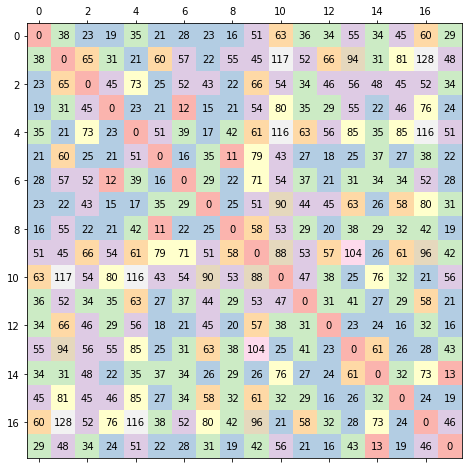

SMAPE


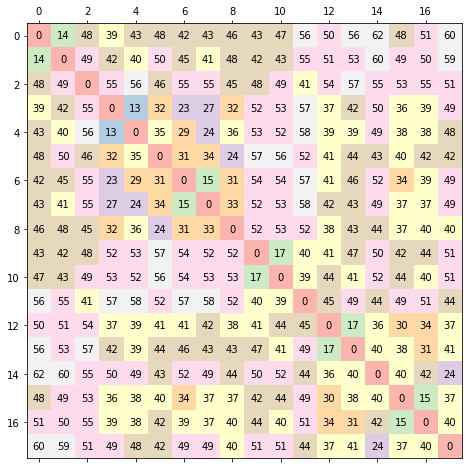

In [10]:
dir_path = 'temp/'
file_list = os.listdir(dir_path)
df_list = []
for i, file in enumerate(file_list):
    if file[-4:] == '.csv':
        print(file)
        df = pd.read_csv(dir_path + file)
        df_list.append(df)
print('')
    
column_1 = df_list[0].columns[0]
column_2 = df_list[0].columns[1:]
meter_id = df_list[0][column_1].values
meter_id = meter_id.reshape(len(meter_id), 1)

values = []
for df in df_list:
    value = df[column_2].values
    values.append(value)
values = np.array(values)

scores_1 = []
scores_2 = []
for i in range(values.shape[0]):
    tmp_1 = []
    tmp_2 = []
    for j in range(values.shape[0]):
        score = (1-r2_score(values[i].flatten(), values[j].flatten()))*10000
        tmp_1.append(score)
        score = smape(values[i], values[j])*10
        tmp_2.append(score)
    scores_1.append(tmp_1)
    scores_2.append(tmp_2)
scores_1 = np.array(scores_1)
scores_2 = np.array(scores_2)

print('1 - R2 score')
fig, ax = plt.subplots(figsize=(10,8))
ax.matshow(scores_1, cmap='Pastel1')
for (i, j), z in np.ndenumerate(scores_1):
    ax.text(i, j, '{:0.0f}'.format(z), ha='center', va='center')
plt.show()

print('SMAPE')
fig, ax = plt.subplots(figsize=(10,8))
ax.matshow(scores_2, cmap='Pastel1')
for (i, j), z in np.ndenumerate(scores_2):
    ax.text(i, j, '{:0.0f}'.format(z), ha='center', va='center')
plt.show()

In [11]:
scores_1_mean = np.mean(scores_1, axis=0)
scores_2_mean = np.mean(scores_2, axis=0)
outputs = []
for i in range(len(scores_1_mean)):
    if (scores_1_mean[i] <= np.median(scores_1_mean)) and (scores_2_mean[i] <= np.median(scores_2_mean)):
        print(str(i).zfill(2) + ', R2: %0.4f, SMAPE: %0.4f'%(scores_1_mean[i], scores_2_mean[i]))
        outputs.append(values[i])
outputs = np.array(outputs)
output = np.mean(outputs, axis=0)
output = np.append(meter_id, output, axis=1)
column = list([column_1]) + list(column_2)
df = pd.DataFrame(output, columns=column)
df.to_csv('submission.csv', header=True, index=False)

df.head()

03, R2: 33.7964, SMAPE: 37.7398
05, R2: 31.0329, SMAPE: 39.8257
06, R2: 34.3249, SMAPE: 38.6675
08, R2: 29.7066, SMAPE: 38.5529
12, R2: 31.9266, SMAPE: 37.6247


,meter_id,X2018_7_1_1h,X2018_7_1_2h,X2018_7_1_3h,X2018_7_1_4h,X2018_7_1_5h,X2018_7_1_6h,X2018_7_1_7h,X2018_7_1_8h,X2018_7_1_9h,...,X2018_7_6_d,X2018_7_7_d,X2018_7_8_d,X2018_7_9_d,X2018_7_10_d,X2018_7_m,X2018_8_m,X2018_9_m,X2018_10_m,X2018_11_m
0,X5,6.48129,6.26135,6.23097,6.24331,6.20321,6.11588,5.77004,6.12644,6.25815,...,148.635,149.776,151.501,148.204,149.435,4618.22,4581.4,4276.29,4446.66,4289.8
1,X7,1.11317,1.13798,1.058,1.20412,1.05742,1.12961,1.2159,2.55484,2.5038,...,38.9259,40.3572,40.6809,34.655,33.8623,1118.96,1073.06,1001.08,1013.71,989.026
2,X10,2.33874,2.2485,2.18589,2.20831,2.17899,2.13405,2.15631,4.73164,7.10854,...,85.7427,100.885,102.738,62.4326,69.4961,2424.12,2308.19,2177.58,2195.84,2144.05
3,X16,3.4121,3.40248,3.2666,3.22905,3.25256,3.26824,3.13366,3.25809,4.24207,...,110.532,114.896,116.401,106.229,106.943,3385.72,3276.82,2929.62,3026.64,2919.33
4,X18,2.5875,2.58552,2.5993,2.607,2.61244,2.61058,2.78532,2.70228,2.6538,...,61.8834,62.343,62.1738,60.8419,60.7015,1906.43,1907.28,1847.5,1910.85,1857.31
